In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#XGBoost Model with applying Best Hyperparameter Tuning

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Load dataset
file_path = "/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Keep only relevant columns
df = df[['text_ner', 'Adaptive']]
df.columns = ['text', 'label']

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Split data into training & testing sets (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['binary_label'],
                                                    test_size=0.2, stratify=df['binary_label'], random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Use unigrams & bigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Compute class weights to penalize the majority class
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.array([0, 1]),
                                     y=y_train)

scale_pos_weight = class_weights[1] / class_weights[0]  # For XGBoost 'scale_pos_weight'

# Apply SMOTE with a lower sampling strategy
smote = SMOTE(sampling_strategy=0.6, random_state=42)  # 60% oversampling of minority class
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              eval_metric='logloss',
                              scale_pos_weight=scale_pos_weight,  # Adjust for class imbalance
                              use_label_encoder=False,
                              random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.7, 1.0]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_tfidf_resampled, y_train_resampled)

# Train the best model from GridSearchCV
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_tfidf_resampled, y_train_resampled)

# Make predictions
y_pred = best_xgb.predict(X_test_tfidf)

# Print classification report
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.81      0.87      0.84        77
           1       0.41      0.30      0.35        23

    accuracy                           0.74       100
   macro avg       0.61      0.59      0.59       100
weighted avg       0.72      0.74      0.73       100



#XGBoost by applying class weights

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original Data Distribution:
binary_label
0    387
1    113
Name: count, dtype: int64

Balanced Data Distribution:
binary_label
0    113
1    113
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        23
           1       0.60      0.52      0.56        23

    accuracy                           0.59        46
   macro avg       0.59      0.59      0.59        46
weighted avg       0.59      0.59      0.59        46


Confusion Matrix:
[[15  8]
 [11 12]]


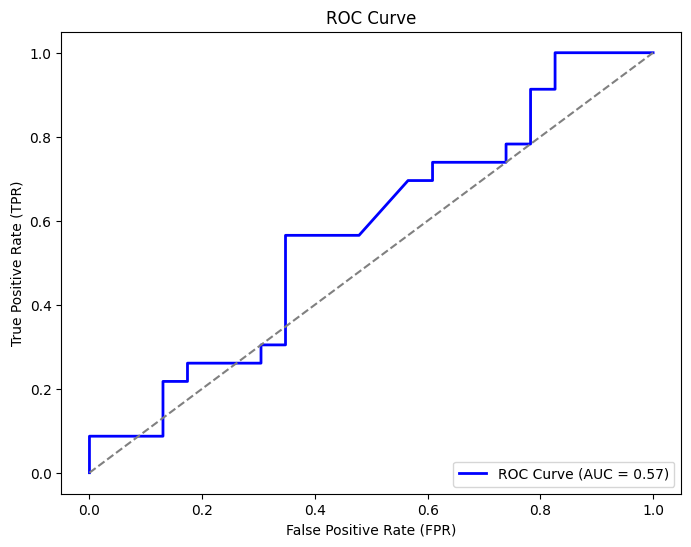

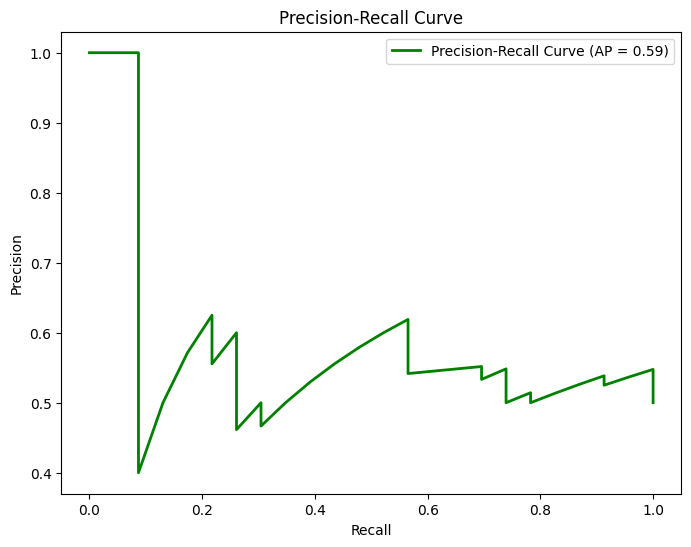

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Load dataset
file_path = "/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Drop irrelevant columns (keeping text and labels)
df = df[['text_ner', 'Adaptive']]

# Rename columns for clarity
df.columns = ['text', 'label']

# Drop missing values
df.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Define a function to clean text
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # Remove named entities
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Check dataset distribution
print("Original Data Distribution:")
print(df['binary_label'].value_counts())

# Separate adaptive and maladaptive cases
adaptive = df[df['binary_label'] == 0]
maladaptive = df[df['binary_label'] == 1]

# Downsample adaptive to match maladaptive count
adaptive_downsampled = resample(adaptive,
                                replace=False,
                                n_samples=len(maladaptive),
                                random_state=42)

# Combine new balanced dataset
df_balanced = pd.concat([adaptive_downsampled, maladaptive])

# Check new distribution
print("\nBalanced Data Distribution:")
print(df_balanced['binary_label'].value_counts())

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))  # Use unigrams and bigrams

# Transform text into numerical features
X = vectorizer.fit_transform(df_balanced['cleaned_text'])
y = df_balanced['binary_label']

# Split data into train-test sets (80-20 split) with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',        # Evaluation metric
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle class imbalance
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for Class 1 (maladaptive)

# Evaluate model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()